In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from src.utils import load_json
from src.config import filepaths

In [8]:
# Load experiments.csv

res_dir = filepaths["model_evals"] / "gnn" 
exp = pd.read_csv(res_dir / "experiments.csv", sep='\t', index_col=0)
exp.tail()

,n_epochs,pred_head,message_passing,agg,d_h_encoder,model,featurizer,encoder_depth,toc,n_splits,split_strategy,neg_multiple,embed_type,seed,dataset_name,split_sim_threshold,embed_dim
303,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,3.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.4,1280
304,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,4.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.4,1280
305,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,5.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.4,1280
306,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,3.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280
307,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,3.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280


In [9]:
# Bring in test scores

for hi, row in exp.iterrows():
    agg_scores = defaultdict(list)
    n_splits = row['n_splits']
    for si in range(n_splits):
        scores = load_json(f"{res_dir}/{hi}_hp_idx_split_{si+1}_of_{n_splits}/version_0/test_scores.json")
        for name, val in scores.items():
            agg_scores[name].append(val)

    if hi == 0:
        for name in agg_scores.keys():
            exp[f"{name}_mean"] = np.NaN
            exp[f"{name}_sem"] = np.NaN
    
    for name, val in agg_scores.items():
        exp.loc[hi, f"{name}_mean"] = np.array(val).mean()
        exp.loc[hi, f"{name}_sem"] = np.array(val).std() / np.sqrt(n_splits)

exp.tail()

,n_epochs,pred_head,message_passing,agg,d_h_encoder,model,featurizer,encoder_depth,toc,n_splits,...,split_sim_threshold,embed_dim,f1_mean,f1_sem,precision_mean,precision_sem,recall_mean,recall_sem,accuracy_mean,accuracy_sem
303,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,3.0,v3_folded_pt_ns,5,...,0.4,1280,0.852532,0.013886,0.940564,0.008250,0.780653,0.020661,0.867272,0.008843
304,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,4.0,v3_folded_pt_ns,5,...,0.4,1280,0.856234,0.010086,0.944056,0.007811,0.783710,0.013267,0.870004,0.005960
305,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,5.0,v3_folded_pt_ns,5,...,0.4,1280,0.863076,0.012176,0.944353,0.006863,0.795273,0.017209,0.875791,0.007466
306,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,3.0,v3_folded_pt_ns,5,...,0.4,1280,0.618318,0.058352,0.900353,0.008018,0.483448,0.059222,0.728683,0.031998
307,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,3.0,v3_folded_pt_ns,5,...,0.4,1280,0.617047,0.055214,0.891522,0.008244,0.483242,0.056662,0.725989,0.030947


In [11]:
# Filter, sort, order cols for display

filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
cols_to_display = [
    # 'toc',
    'model',
    'agg',
    'pred_head',
    'featurizer',
    'd_h_encoder',
    'encoder_depth',
    'n_epochs',
    'f1_mean',
    'precision_mean',
    'recall_mean',
    'accuracy_mean',
    'f1_sem',
    'precision_sem',
    'recall_sem',
    'accuracy_sem'
]
sortby = ['f1_mean']

display_res = exp.loc[filter_by_toc & filter_by_task, cols_to_display]
display_res.sort_values(by=sortby, ascending=False).head(40)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
87,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,25,0.886270,0.952134,0.830487,0.895217,0.016006,0.008622,0.025048,0.012663
86,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,25,0.886166,0.951878,0.831673,0.895761,0.019801,0.007895,0.032029,0.015556
118,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,35,0.885574,0.954863,0.827638,0.895109,0.017125,0.007123,0.027435,0.013328
117,mpnn_dim_red,mean,dot_sig,rxn_rc,300,2.0,35,0.884306,0.950029,0.829164,0.893704,0.017699,0.008072,0.028312,0.013741
101,mpnn_dim_red,mean,binary,rxn_rc,300,2.0,25,0.883464,0.943294,0.832719,0.892594,0.019097,0.009029,0.029385,0.014727
83,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,25,0.882599,0.941190,0.832293,0.891252,0.017325,0.010572,0.025690,0.013593
103,mpnn_dim_red,mean,binary,rxn_rc,300,4.0,25,0.882468,0.944783,0.829353,0.891635,0.017827,0.009285,0.026607,0.013835
100,mpnn_dim_red,mean,binary,rxn_rc,300,1.0,25,0.882072,0.937093,0.835747,0.891373,0.022414,0.009873,0.034487,0.017476
258,mpnn_dim_red,mean,dot_sig,rxn_rc,300,5.0,25,0.881649,0.950961,0.823630,0.891513,0.017438,0.008340,0.027340,0.013471
133,mpnn_dim_red,mean,binary,rxn_rc,300,2.0,35,0.881479,0.946997,0.826887,0.891884,0.021892,0.008832,0.033349,0.016570


In [13]:
# Display all w/in MOE of best

best = 87
metric = 'f1'
metric_mean, metric_sem = f"{metric}_mean", f"{metric}_sem"
filter_by_performance = (display_res.loc[best, metric_mean] - display_res[metric_mean] < display_res.loc[best, metric_sem])
display_res.loc[filter_by_performance].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
87,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,25,0.886270,0.952134,0.830487,0.895217,0.016006,0.008622,0.025048,0.012663
86,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,25,0.886166,0.951878,0.831673,0.895761,0.019801,0.007895,0.032029,0.015556
118,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,35,0.885574,0.954863,0.827638,0.895109,0.017125,0.007123,0.027435,0.013328
117,mpnn_dim_red,mean,dot_sig,rxn_rc,300,2.0,35,0.884306,0.950029,0.829164,0.893704,0.017699,0.008072,0.028312,0.013741
101,mpnn_dim_red,mean,binary,rxn_rc,300,2.0,25,0.883464,0.943294,0.832719,0.892594,0.019097,0.009029,0.029385,0.014727
83,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,25,0.882599,0.941190,0.832293,0.891252,0.017325,0.010572,0.025690,0.013593
103,mpnn_dim_red,mean,binary,rxn_rc,300,4.0,25,0.882468,0.944783,0.829353,0.891635,0.017827,0.009285,0.026607,0.013835
100,mpnn_dim_red,mean,binary,rxn_rc,300,1.0,25,0.882072,0.937093,0.835747,0.891373,0.022414,0.009873,0.034487,0.017476
258,mpnn_dim_red,mean,dot_sig,rxn_rc,300,5.0,25,0.881649,0.950961,0.823630,0.891513,0.017438,0.008340,0.027340,0.013471
133,mpnn_dim_red,mean,binary,rxn_rc,300,2.0,35,0.881479,0.946997,0.826887,0.891884,0.021892,0.008832,0.033349,0.016570


In [14]:
# VN agg, how large of a radius?

filter_vn_agg = (display_res['agg'] == 'last') & (display_res['featurizer'] == 'rxn_rc') & (display_res['pred_head'] != 'binary')
display_res.loc[filter_vn_agg & filter_by_performance].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
94,mpnn_dim_red,last,dot_sig,rxn_rc,300,3.0,25,0.881189,0.943213,0.828850,0.890474,0.018631,0.009151,0.029028,0.014697
126,mpnn_dim_red,last,dot_sig,rxn_rc,300,3.0,35,0.880719,0.939774,0.830055,0.889577,0.017766,0.010247,0.026251,0.014026
95,mpnn_dim_red,last,dot_sig,rxn_rc,300,4.0,25,0.879729,0.940019,0.828769,0.888967,0.018970,0.011321,0.028960,0.014951
127,mpnn_dim_red,last,dot_sig,rxn_rc,300,4.0,35,0.878687,0.945687,0.822530,0.888717,0.019072,0.009678,0.029044,0.014941
256,mpnn_dim_red,last,dot_sig,rxn_rc,300,5.0,25,0.878517,0.939935,0.826678,0.888308,0.021790,0.013711,0.031473,0.017344
257,mpnn_dim_red,last,dot_sig,rxn_rc,300,6.0,25,0.873835,0.929757,0.826175,0.882674,0.018447,0.010565,0.028075,0.014982
123,mpnn_dim_red,last,dot_sig,rxn_rc,50,4.0,35,0.872402,0.935818,0.820244,0.883315,0.023566,0.011642,0.036333,0.018499
93,mpnn_dim_red,last,dot_sig,rxn_rc,300,2.0,25,0.871133,0.935515,0.818497,0.882411,0.024924,0.009459,0.038542,0.019812
90,mpnn_dim_red,last,dot_sig,rxn_rc,50,3.0,25,0.871053,0.934224,0.819532,0.882192,0.024575,0.010329,0.038564,0.019392


In [ ]:
# Non-GNN benchmarks
filter_non_gnn = (display_res['model'] == 'ffn') | (display_res['model'] == 'linear')
display_res.loc[filter_non_gnn].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
185,linear,NaN,dot_sig,mfp,300,NaN,25,0.717689,0.943746,0.584895,0.784827,0.033938,0.004400,0.043090,0.024183
187,linear,NaN,dot_sig,mfp,300,NaN,35,0.713790,0.941233,0.583255,0.782087,0.038958,0.006469,0.049749,0.027349
186,linear,NaN,dot_sig,mfp,50,NaN,35,0.710052,0.926764,0.582240,0.777073,0.034257,0.007515,0.044066,0.024932
184,linear,NaN,dot_sig,mfp,50,NaN,25,0.696475,0.923728,0.564173,0.768702,0.031604,0.008089,0.039301,0.023386


# Loss curves

In [12]:
hp_idx = 119
gs_path = f"/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn"
n_splits = 5

loss_curves = defaultdict(lambda: defaultdict()) # 'hpidx_sidx': {epochs: [int], losses: [float])
for sidx in range(n_splits):
    hsd = f"{hp_idx}_hp_idx_split_{sidx + 1}_of_{n_splits}"
    lc = pd.read_csv(f"{gs_path}/{hsd}/version_0/metrics.csv", sep=',')
    ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index() # Average over epochs
    loss_curves[hsd]['epochs'] = ep_ave_lc.loc[:, 'epoch'].to_numpy()
    loss_curves[hsd]['losses'] = ep_ave_lc.loc[:, 'train_loss'].to_numpy()


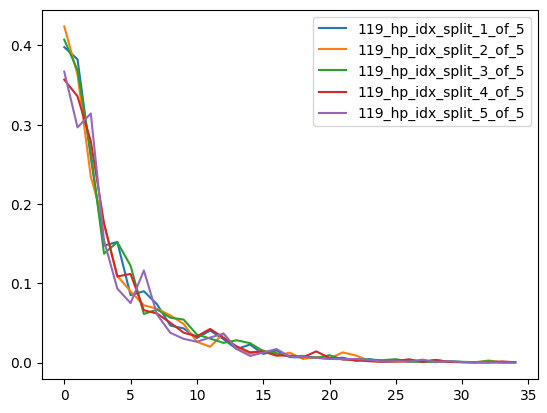

In [13]:
fig, ax = plt.subplots()
for k,v in loss_curves.items():
    ax.plot(v['epochs'], v['losses'], label=k)

ax.legend()
plt.show()

# Performance figures

In [4]:
def clustered_multi_panel_bar_chart(
        extract:pd.DataFrame,
        cluster_sels,
        x_sels,
        metrics,
        cluster_labels,
        x_labels,
        colors,
        xaxis_label=None,
    ):
    if x_sels:
        x = np.arange(-len(cluster_sels) / 2, )
    x = np.arange(max(1, len(x_sels))) # x locations
    width = 0.3  # the width of the bars

    _, ax = plt.subplots(ncols=len(metrics), sharey=True, figsize=(11,3), constrained_layout=True)

    for i, m in enumerate(metrics):
        for j, cs in enumerate(cluster_sels):
            means = []
            errors = []
            if x_sels:
                for k, xs in enumerate(x_sels):
                    means.append(extract.loc[cs & xs, f"{m}_mean"].to_numpy()[0])
                    errors.append(extract.loc[cs & xs, f"{m}_sem"].to_numpy()[0])
            else:
                means.append(extract.loc[cs, f"{m}_mean"].to_numpy()[0])
                errors.append(extract.loc[cs, f"{m}_sem"].to_numpy()[0])
                
            offset = width * (j - (len(cluster_sels) / 2) + 0.5)
            rects = ax[i].bar(x + offset, means, yerr=errors, width=width, label=cluster_labels[j], color=colors[j])
            ax[i].set_xticks(x)
            ax[i].set_xticklabels(x_labels)
            ax[i].set_title(f"{m.capitalize()}")

    ax[-1].legend(loc='lower right', fontsize=11)
    ax[0].set_ylim(0.5, 1)
    ax[0].set_yticks(np.arange(0.4, 1.05, 0.1))
    if xaxis_label:
        ax[0].set_xlabel(xaxis_label)
    plt.show()


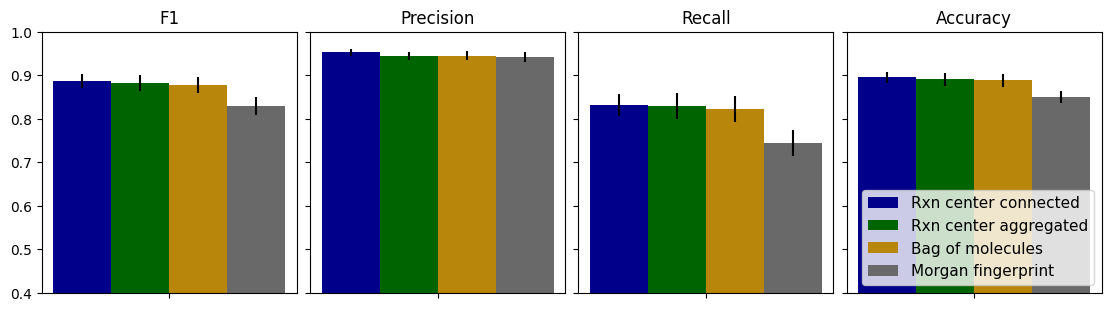

In [5]:
# Compare best & benchmarks on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
mfp = (exp['featurizer'] == 'mfp')

tmp = []
for sel in [bag_of_mols, rc_aug, rc_agg, mfp]:
    slice = exp.loc[sel & common]
    arg_best = slice[srt_metric_mean].idxmax()
    tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head()


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
    mfp
]

x_sels = [
    
]

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
    "Morgan fingerprint"
]

x_labels = [

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    "dimgray",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

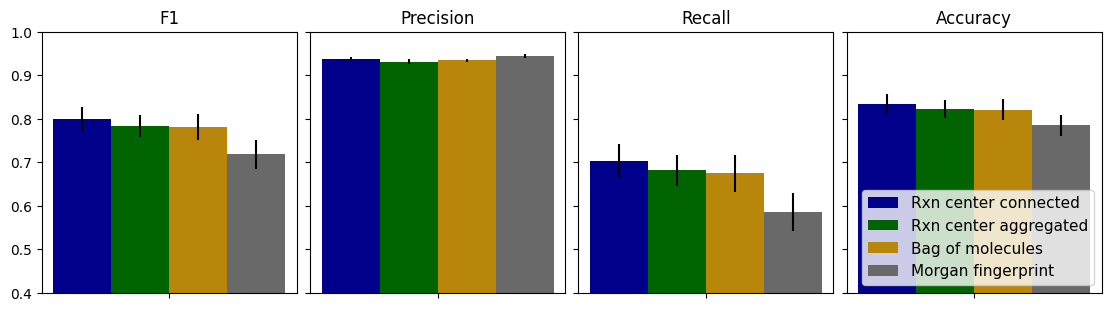

In [6]:
# Compare best & benchmarks on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = (exp['featurizer'] == 'rxn_simple')
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
mfp = (exp['featurizer'] == 'mfp')

tmp = []
for sel in [bag_of_mols, rc_aug, rc_agg, mfp]:
    slice = exp.loc[sel & common]
    arg_best = slice[srt_metric_mean].idxmax()
    tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head()


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
    mfp
]

x_sels = [
    
]

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
    "Morgan fingerprint"
]

x_labels = [

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    "dimgray",
    
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

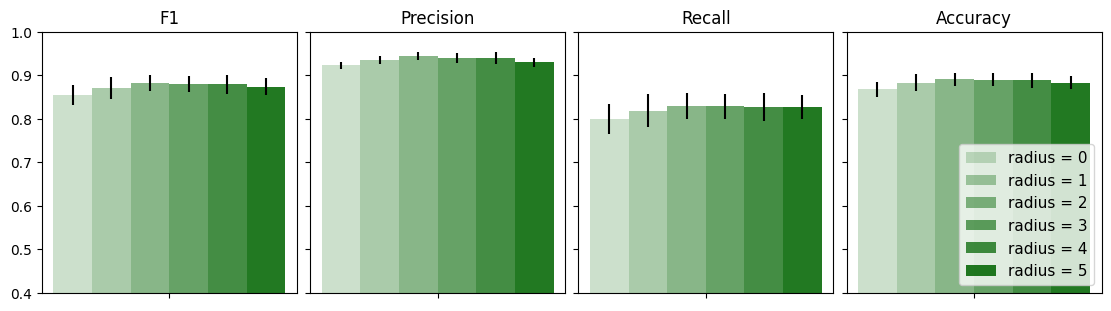

In [7]:
# Compare RC radius on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

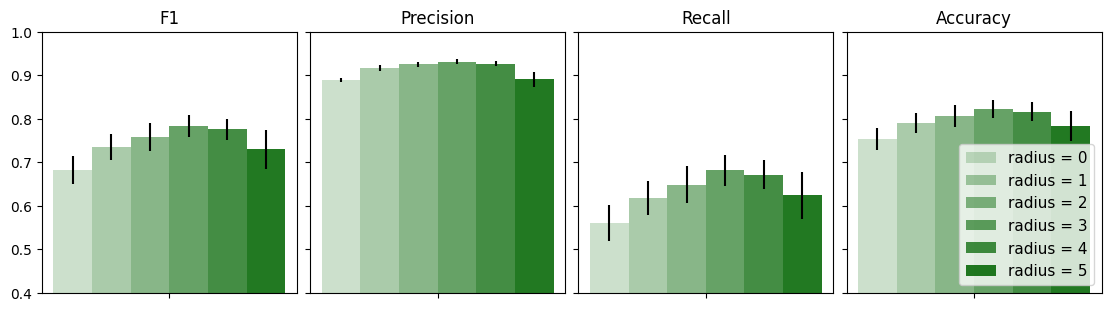

In [8]:
# Compare RC radius on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

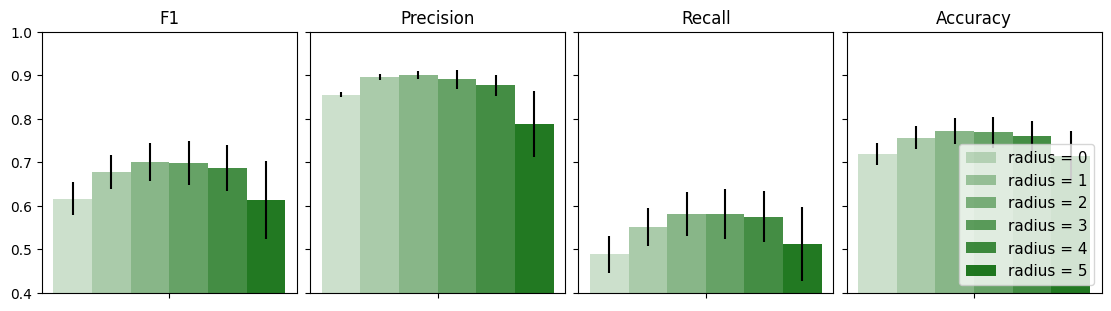

In [9]:
# Compare RC radius on 60% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.6)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

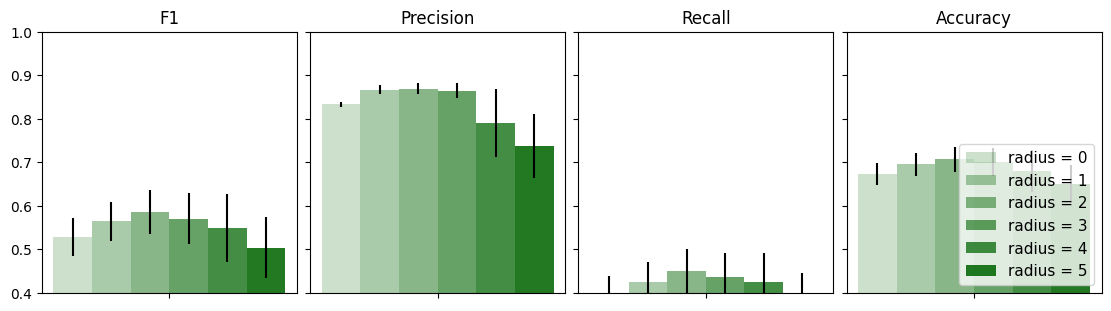

In [10]:
# Compare RC radius on 40% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.4)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

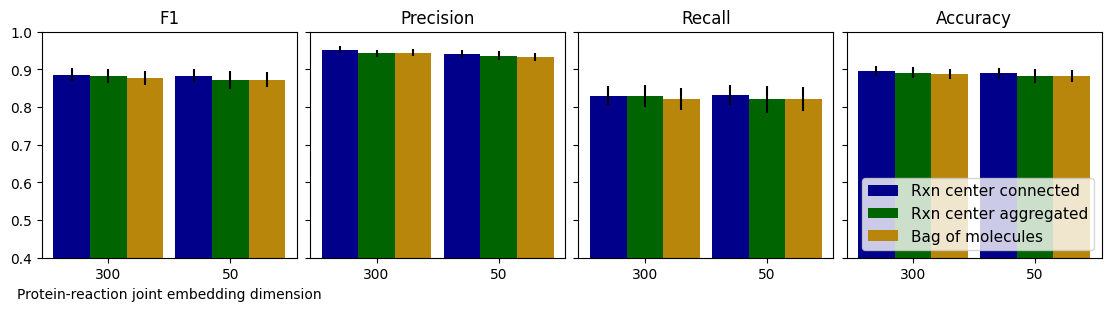

In [11]:
# Compare best models w/ diff hidden dimensions on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')



metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['d_h_encoder'] == 300,
    exp['d_h_encoder'] == 50,
    
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "300",
    "50",
]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="Protein-reaction joint embedding dimension",
)

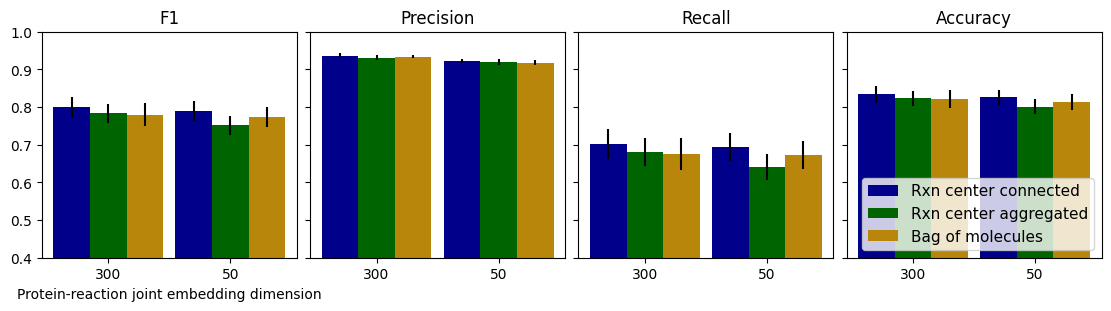

In [12]:
# Compare best models w/ diff hidden dimensions on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')



metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['d_h_encoder'] == 300,
    exp['d_h_encoder'] == 50,
    
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head(20)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "300",
    "50",
]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="Protein-reaction joint embedding dimension",
)

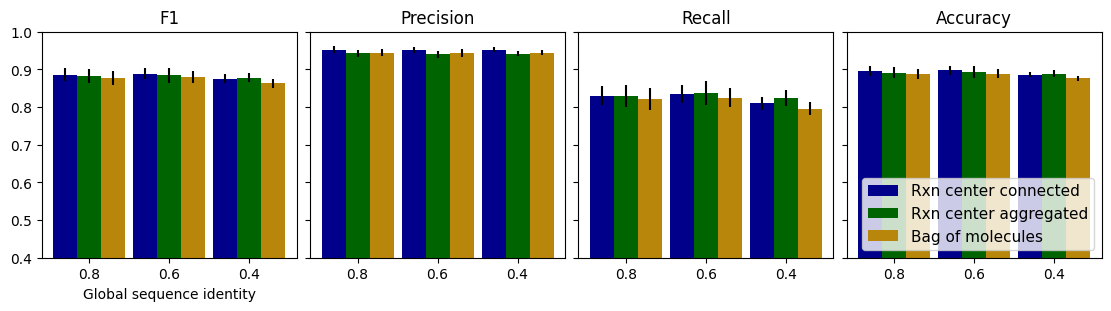

In [13]:
# Compare best & benchmarks on various homology ubs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology')
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['split_sim_threshold'] == 0.8,
    exp['split_sim_threshold'] == 0.6,
    exp['split_sim_threshold'] == 0.4,
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "0.8",
    "0.6",
    "0.4",

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="Global sequence identity"
)

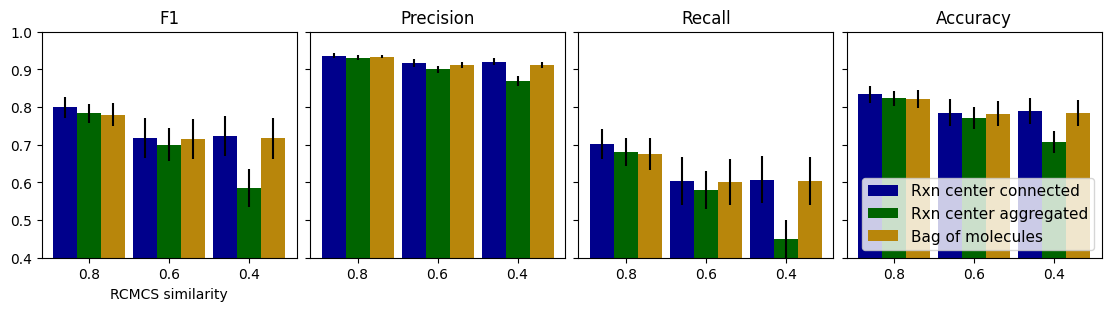

In [14]:
# Compare best & benchmarks on various rcmcs ubs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs')
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['split_sim_threshold'] == 0.8,
    exp['split_sim_threshold'] == 0.6,
    exp['split_sim_threshold'] == 0.4,
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "0.8",
    "0.6",
    "0.4",

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="RCMCS similarity"
)